In [1]:
# %pip install matplotlib pandas seaborn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device=0

print(device)
print(torch.cuda.get_device_name(0))

0
NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
print(torch.__version__)

2.5.1+cu121


In [5]:
torch.manual_seed(42)

In [7]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Transform (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize all images to same size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets
# 2. Load Datasets from folder
Datasets=datasets.ImageFolder(root="/home/aastha_same/Documents/Project to learn/Agriculture_Potato_Disease_Classification_1/Data/Data", transform=transform)
# img, label = Datasets[0]

# Class names
classes = Datasets.classes
print("Classes:", classes)

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']


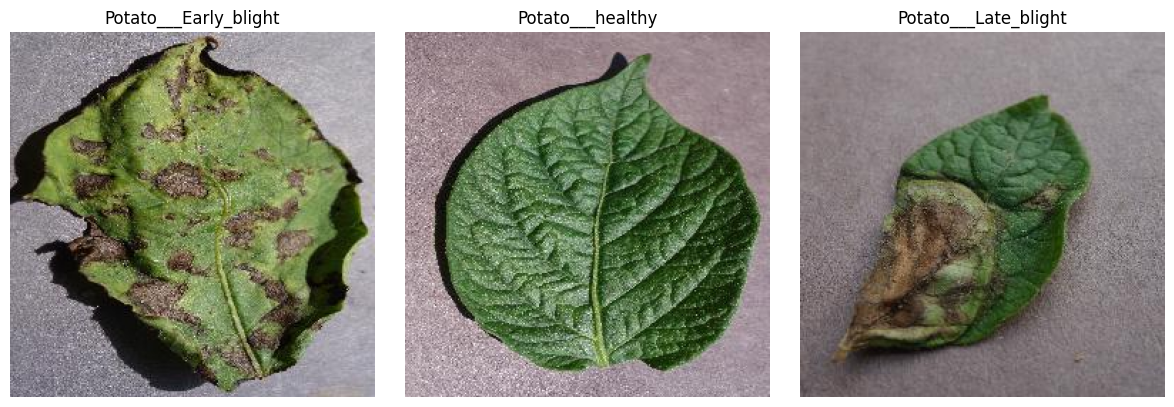

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
base_path='/home/aastha_same/Documents/Project to learn/Agriculture_Potato_Disease_Classification_1/Data/Data'
folders=os.listdir(base_path)
print(folders)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, folder in enumerate(folders):
    folder_path = os.path.join(base_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    img_path = os.path.join(folder_path, image_files[0])  # Take the first image from each folder
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(folder)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

3. Split into Training and Validation Sets --

In [8]:
# 3. Split into train & val
from torch.utils.data import random_split
train_size = int(0.8 * len(Datasets))
val_size = len(Datasets) - train_size

train_dataset, val_dataset = random_split(Datasets, [train_size, val_size])

print("Training images:", len(train_dataset))
print("Validation images:", len(val_dataset))

# 4. Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

Training images: 1721
Validation images: 431


In [9]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [10]:
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
# --- 5. Inspect a Batch (Optional) ---
# Let's see what the DataLoader gives us.
# next(iter(...)) gets one batch.
images, labels = next(iter(train_loader))

print(f"\n--- Inspecting one batch ---")
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Example labels: {labels}")


--- Inspecting one batch ---
Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Example labels: tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0, 2,
        0, 0, 1, 0, 0, 1, 1, 1])


In [12]:
from collections import Counter

# Folder-wise image counts
labels = [label for _, label in train_dataset]
counter = Counter(labels)

for i, c in enumerate(classes):
    print(f"{c}: {counter[i]} images")


Potato___Early_blight: 790 images
Potato___Late_blight: 808 images
Potato___healthy: 123 images


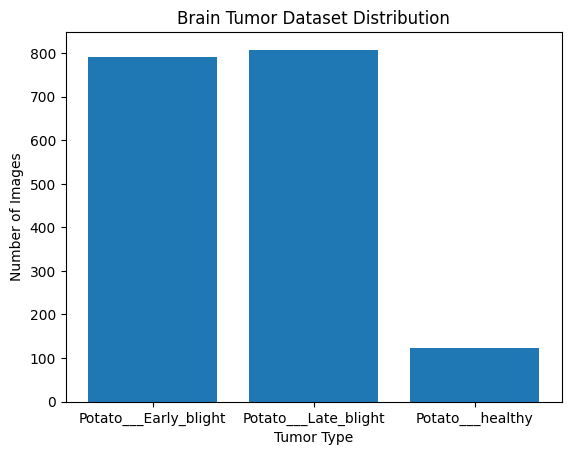

In [13]:
plt.bar(classes, [counter[i] for i in range(len(classes))])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Brain Tumor Dataset Distribution")
plt.show()


PyTorch Training Pipeline

In [14]:
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features=nn.Sequential(
#             nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#             nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#             nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#             nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#             nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#             nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#         )
#         self.classifier=nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=1024*3*3,out_features=256),
#             nn.ReLU(),
#             nn.Linear(in_features=256,out_features=128),
#             nn.ReLU(),
#             nn.Linear(in_features=128,out_features=64),
#             nn.ReLU(),
#             nn.Linear(in_features=64,out_features=32),
#             nn.ReLU(),
#             nn.Linear(in_features=32,out_features=3)
#         )
#     def forward(self,x):
#         x=self.features(x)
#         x=self.classifier(x)
#         return x



class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [8]:
num_classes = len(classes)
num_classes

3

Training Parameters

In [17]:
model = CNN(num_classes)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()   # correct for multi-class
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
batch_features,batch_labels=next(iter(train_loader))
batch_features.shape,batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [20]:
epochs=15

Training loop

10 ephocs 

In [21]:
# %pip install tqdm

In [22]:
# %pip install scikit-learn

In [24]:
criterion = nn.CrossEntropyLoss()   # correct for multi-class
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2
)


epochs = 10
patience = 4
best_val_loss = float("inf")
counter = 0

from tqdm import tqdm
import time
from sklearn.metrics import classification_report

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    start_time = time.time()

    # ================= TRAINING =================
    model.train()
    total_epoch_loss = 0.0
    correct = 0
    total = 0

    for batch_features, batch_labels in tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"
    ):
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        loss.backward()

        # Gradient clipping (stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    avg_train_loss = total_epoch_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # ================= VALIDATION =================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_features, val_labels in tqdm(
            val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"
        ):
            val_features = val_features.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_features)
            v_loss = criterion(val_outputs, val_labels)

            val_loss += v_loss.item()

            _, v_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (v_predicted == val_labels).sum().item()

            all_preds.extend(v_predicted.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    # Scheduler step
    scheduler.step(avg_val_loss)

    # ================= EARLY STOPPING =================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "agriculture_model.pth")
    else:
        counter += 1

    epoch_time = time.time() - start_time

    # ================= LOGGING =================
    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"- Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
        f"- Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}% "
        f"- Time: {epoch_time:.2f}s"
    )

    if counter >= patience:
        print("Early stopping triggered")
        break
# ================= FINAL EVALUATION =================
print("\nClassification Report (Validation Set):")
print(classification_report(all_labels, all_preds, target_names=classes))


Epoch 1/10 [Val]: 100%|██████████| 14/14 [00:01<00:00, 11.94it/s]


Epoch [1/10] - Train Loss: 0.2175, Train Acc: 93.20% - Val Loss: 0.1187, Val Acc: 98.14% - Time: 6.50s


Epoch 2/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 15.94it/s]


Epoch [2/10] - Train Loss: 0.1386, Train Acc: 95.93% - Val Loss: 0.1065, Val Acc: 96.29% - Time: 6.62s


Epoch 3/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 15.88it/s]


Epoch [3/10] - Train Loss: 0.1245, Train Acc: 95.82% - Val Loss: 0.1091, Val Acc: 96.98% - Time: 6.38s


Epoch 4/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 16.07it/s]


Epoch [4/10] - Train Loss: 0.1161, Train Acc: 96.11% - Val Loss: 0.2466, Val Acc: 89.56% - Time: 6.10s


Epoch 5/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 14.69it/s]


Epoch [5/10] - Train Loss: 0.0974, Train Acc: 96.17% - Val Loss: 0.1431, Val Acc: 95.13% - Time: 6.54s


Epoch 6/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 16.00it/s]


Epoch [6/10] - Train Loss: 0.1012, Train Acc: 97.04% - Val Loss: 0.0556, Val Acc: 98.84% - Time: 6.42s


Epoch 7/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 16.61it/s]


Epoch [7/10] - Train Loss: 0.0817, Train Acc: 97.39% - Val Loss: 0.0912, Val Acc: 96.29% - Time: 6.25s


Epoch 8/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 14.55it/s]


Epoch [8/10] - Train Loss: 0.0825, Train Acc: 96.98% - Val Loss: 0.0636, Val Acc: 97.45% - Time: 6.40s


Epoch 9/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 16.45it/s]


Epoch [9/10] - Train Loss: 0.0706, Train Acc: 97.79% - Val Loss: 0.0458, Val Acc: 98.84% - Time: 6.22s


Epoch 10/10 [Val]: 100%|██████████| 14/14 [00:00<00:00, 15.08it/s]

Epoch [10/10] - Train Loss: 0.0718, Train Acc: 97.62% - Val Loss: 0.0539, Val Acc: 98.38% - Time: 6.46s

Classification Report (Validation Set):
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.99      0.99       210
 Potato___Late_blight       0.97      0.99      0.98       192
     Potato___healthy       1.00      0.86      0.93        29

             accuracy                           0.98       431
            macro avg       0.99      0.95      0.97       431
         weighted avg       0.98      0.98      0.98       431



In [25]:
model.eval()  # turn off dropout, batchnorm, etc.

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)

In [26]:
# for epoch in range(epochs):
#     total_epoch_loos=0

#     for batch_features,batch_labels in train_loader:

#         # MOve the data to GPU
#         batch_features=batch_features.to(device)
#         batch_labels=batch_labels.to(device)

#         # forwares pass
#         outputs=model(batch_features)
#         # Calculate the loss
#         loss=criterion(outputs,batch_labels)
#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()

#         #update grads

#         optimizer.step()
        
#         total_epoch_loos+=loss.item()
#     average_epoch_loss=total_epoch_loos/len(train_loader)
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {average_epoch_loss}")
        

20 epochs

In [27]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, y in val_loader:
        # MOve the data to the same device as the model
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = 100 * correct / total
print("Validation Accuracy:", accuracy)


Validation Accuracy: 98.60788863109049


In [28]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, y in train_loader:
        # MOve the data to the same device as the model
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = 100 * correct / total
print("Validation Accuracy:", accuracy)


Validation Accuracy: 98.43114468332365


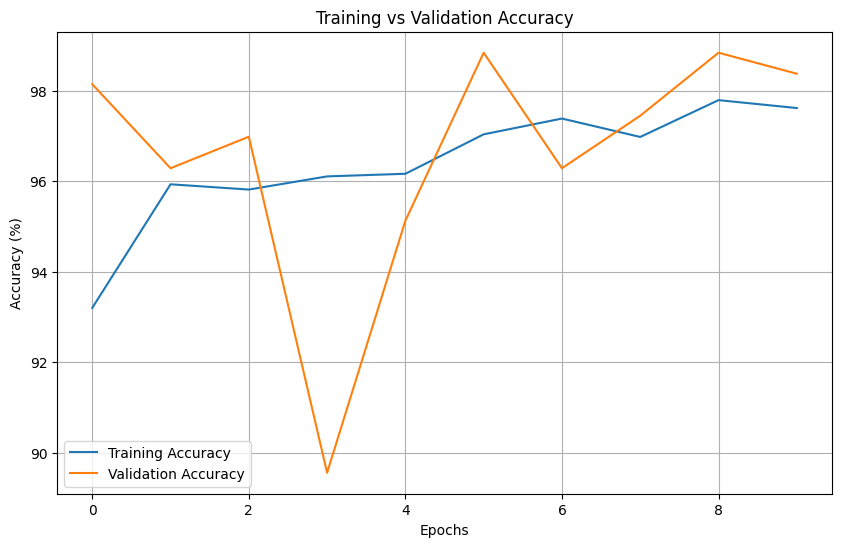

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

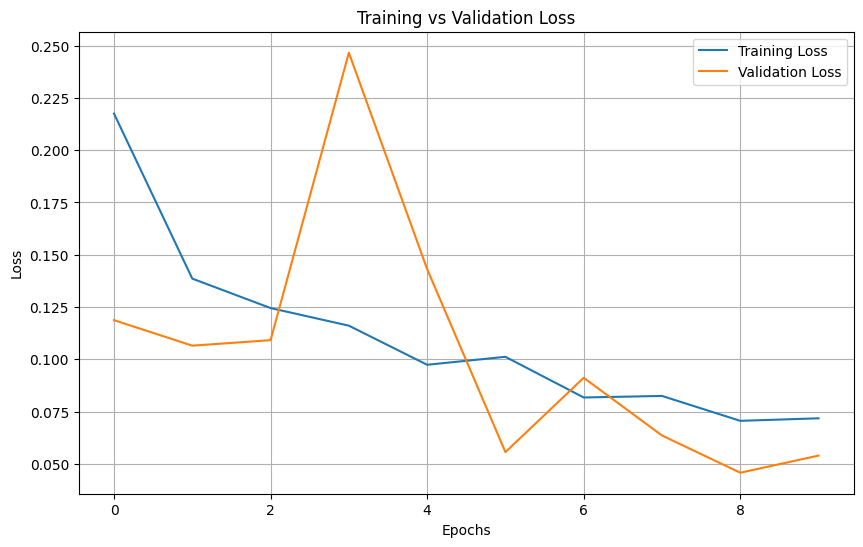

In [30]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
cm = confusion_matrix(all_labels, all_preds)
cm


array([[208,   2,   0],
       [  1, 191,   0],
       [  0,   3,  26]])

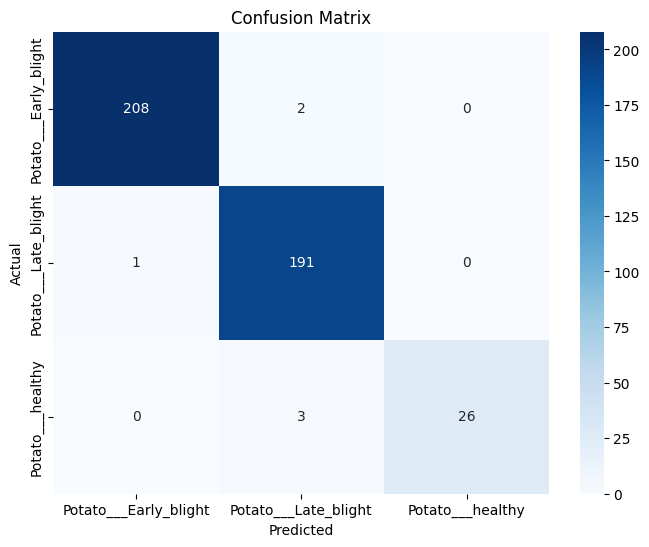

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [42]:
# torch.save(model.state_dict(), "potato_model.pth")


In [10]:
model = CNN(len(classes))                      # your CNN class
model.load_state_dict(torch.load(r"/home/aastha_same/Documents/Project to learn/Agriculture_Potato_Disease_Classification_1/Agriculture_Potato_Disease_classification/API/agriculture_model.pth", map_location="cpu"))
model.eval()

/tmp/ipykernel_154674/2847329061.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"/home/aastha_same/Documents/Project to learn/Agricult

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)

In [13]:
import PIL.Image as Image

In [11]:
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
# Prediction function
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    print(f"\n🧠 Predicted : {classes[predicted.item()]}")
    return classes[predicted.item()]

# Example usage


In [17]:
predict("/home/aastha_same/Documents/Project to learn/Agriculture_Potato_Disease_Classification_1/Agriculture_Potato_Disease_classification/model_training/Healthy (189).jpg")


🧠 Predicted : Potato___healthy


'Potato___healthy'